# Nuwe Challenge - ML - Imbalanced Data
* [Libraries](#libraries)
* [Data Loading](#data-loading)
* [EDA](#eda)
* [Model](#model)
* [Results](#results)

## Libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

plt.style.use("ggplot")

## Data Loading<a class="anchor" id="data-loading"></a>

In [2]:
# importing data
train = pd.read_csv("data/m0001_train.csv")
test = pd.read_csv("data/m0001_X_test.csv")

print(f"Train shape: {train.shape}")
print(f"Train shape: {test.shape}")
Counter(train["target"])

Train shape: (7000, 8)
Train shape: (3000, 7)


Counter({0: 6678, 1: 162, 2: 160})

In [3]:
train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,target
0,3.242358,-0.874756,-1.160856,2.750583,0.357114,-0.695753,0.640694,0
1,0.828152,0.375320,-0.886114,-2.987413,-1.784753,1.804627,-1.770459,0
2,0.757912,0.740729,-0.178221,-2.104649,1.576795,0.473021,0.241264,1
3,-0.265681,-1.240755,-1.539769,0.809344,-1.677894,-0.106865,-1.512280,0
4,-2.033791,0.196793,-0.132785,1.950021,-0.215558,-2.012766,0.458950,2


In [4]:
test.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,-2.805663,-0.302624,-0.678777,0.570482,-1.943084,-0.924866,-1.209460
1,-1.594931,-2.401335,-1.690410,0.678267,0.715743,-0.393227,-1.419346
2,0.885592,-0.226533,-0.893823,1.541492,-1.485168,-0.566309,-0.330251
3,1.218903,0.836470,-2.502494,2.161609,-2.405142,-2.223827,-0.419426
4,-0.932200,-0.901759,-1.291393,-1.076727,-1.280966,0.597166,-1.854865


## EDA<a class="anchor" id="eda"></a>
### Target variable
Las __categorías de la variable objetivo no están balanceadas__, será necesario tratar esto en para entrenar el modelo.

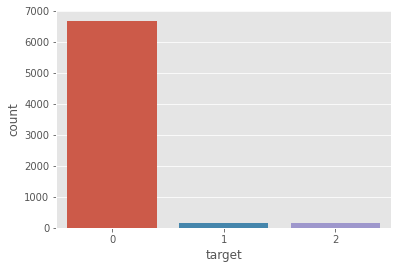

In [5]:
sns.countplot(x="target", data=train)
plt.show()

En un pairplot se observa que las combinaciones de la features permiten identificar las distintas etiquetas de la variable target. La variable 2, 5 y 7 parecen ser las que mejor separan la variable target.

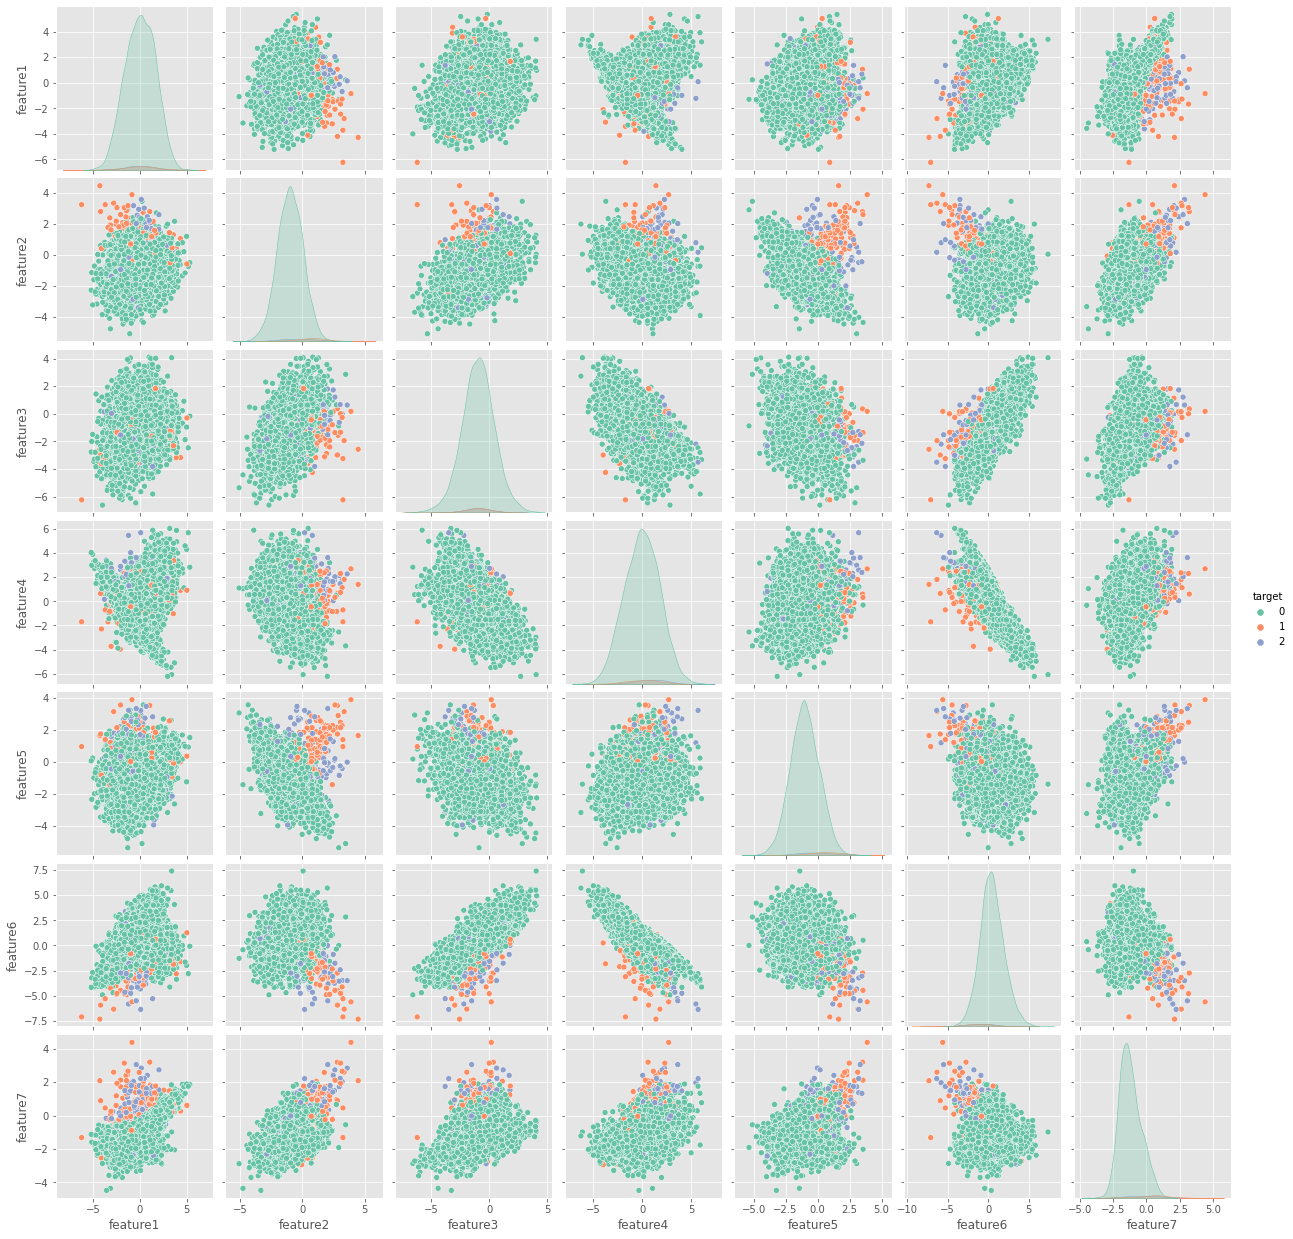

In [6]:
g = sns.pairplot(train, hue="target", palette="Set2", diag_kind="kde", height=2.5)

### Distribution test vs test
__La distribucción de las features en el conjunto de entreno y de test es similar__, por lo que el modelo que entrenemos se puede aplicar sobre el conjunto de test.

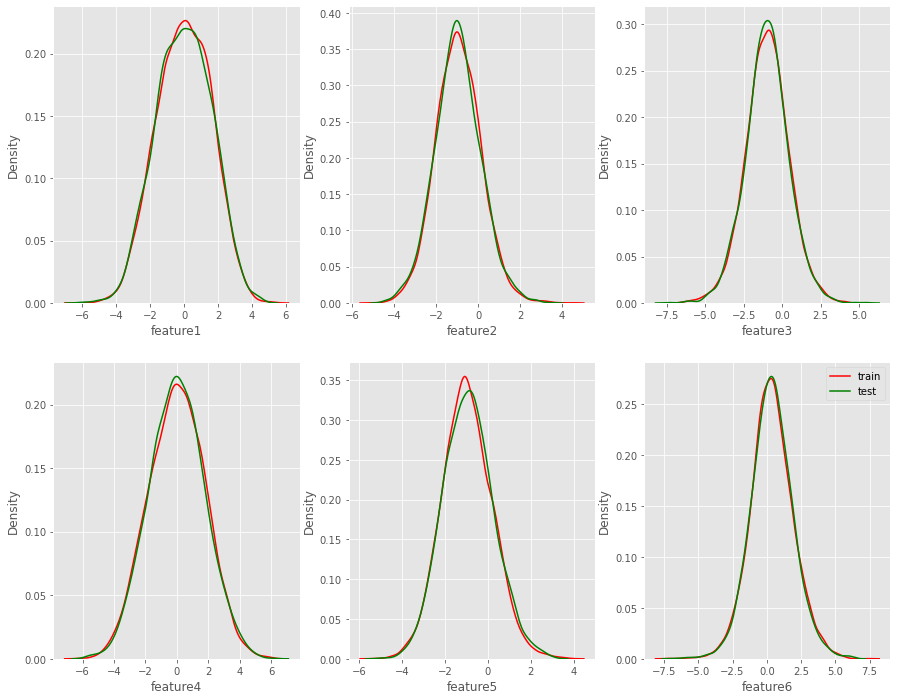

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))
features = test.columns

for feature, ax in zip(features, axes.flat):
    sns.kdeplot(train[feature], shade=0, color="red", ax=ax, label="train")
    sns.kdeplot(test[feature], shade=0, color="green", ax=ax, label="test")

plt.legend()
plt.show()

In [8]:
train.drop(columns=["target"]).describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,0.006262,-0.932516,-0.972335,-0.001401,-0.951912,0.375366,-1.154591
std,1.604982,1.088360,1.420187,1.788680,1.174673,1.567207,0.902826
min,-6.230316,-5.075432,-6.610451,-6.225977,-5.353412,-7.324168,-4.479117
25%,-1.136344,-1.665142,-1.868669,-1.255364,-1.743266,-0.604719,-1.794917
50%,0.052355,-0.957348,-0.956116,0.024775,-0.997887,0.332823,-1.286691
75%,1.179122,-0.223722,-0.072890,1.261277,-0.195576,1.344787,-0.622253
max,5.339048,4.483914,4.113801,6.059379,3.874894,7.404997,4.391218


In [9]:
test.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.005384,-0.960807,-0.980140,-0.005871,-0.904060,0.376683,-1.155974
std,1.622922,1.098999,1.398213,1.761089,1.179164,1.547168,0.908693
min,-5.997562,-4.447264,-7.390544,-5.604774,-4.971009,-6.714767,-3.268691
25%,-1.161573,-1.666686,-1.830941,-1.218767,-1.730584,-0.590398,-1.807827
50%,0.009279,-0.984973,-0.979733,0.006293,-0.920028,0.358940,-1.300100
75%,1.176245,-0.264482,-0.102621,1.164914,-0.136110,1.338460,-0.607305
max,4.559145,3.355021,5.468784,6.020773,3.024921,6.265319,3.818473


## Model<a class="anchor" id="model"></a>
Se ha utilizado un modelo XGboost.

Para solucionar el balanceado de dato se ha utilizado el parámetro sample_weight del xgboost. Se han probado otros métodos como SMOTE pero se han descartado por dar peores resultados.

Se ha utilizado cross validation para obtener mejores resultados.

El resultado f1-score macro sobre el conjunto de test es de 0.79. La classe 2 es la que peor se estima con un f1-score de 0.57.

El gráfico de la importancias de los parámetros confirma que las variables 2, 5 y 7 son las que mejor ayudan a predecir la variable target.

In [10]:
X = train.drop(columns=["target"])
y = train["target"]

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=11
)

skf = StratifiedKFold(n_splits=10)

classifiers = []
accuracies = []
f1_scores = []
auc_scores = []
i = 0
for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # variable para balancear los datos
    classes_weights = class_weight.compute_sample_weight(
        class_weight="balanced", y=y_train
    )

    classifier = xgb.XGBClassifier(
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        learning_rate=0.03,
        n_estimators=2000,
    )
    eval_set = [(X_valid, y_valid)]
    classifier.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        sample_weight=classes_weights,
    )

    predictions = classifier.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    f1_score_value = f1_score(y_valid, predictions, average="macro")
    auc_score = roc_auc_score(
        y_valid, classifier.predict_proba(X_valid), average="macro", multi_class="ovo"
    )
    i += 1
    print(
        f"Fold {i}: accuracy {accuracy:.2f}, f1_score {f1_score_value:.2f}, auc_score {auc_score:.2f}"
    )
    accuracies.append(accuracy)
    f1_scores.append(f1_score_value)
    auc_scores.append(auc_score)
    classifiers.append(classifier)
print(
    f"Mean accuracy: {np.mean(accuracies):.2f}, mean f1_score: {np.mean(f1_scores):.2f}, mean auc_score: {np.mean(auc_scores):.2f}"
)

Fold 1: accuracy 0.98, f1_score 0.83, auc_score 0.92
Fold 2: accuracy 0.97, f1_score 0.69, auc_score 0.79
Fold 3: accuracy 0.98, f1_score 0.79, auc_score 0.81
Fold 4: accuracy 0.97, f1_score 0.67, auc_score 0.82
Fold 5: accuracy 0.97, f1_score 0.79, auc_score 0.86
Fold 6: accuracy 0.97, f1_score 0.78, auc_score 0.86
Fold 7: accuracy 0.97, f1_score 0.73, auc_score 0.89
Fold 8: accuracy 0.97, f1_score 0.75, auc_score 0.81
Fold 9: accuracy 0.98, f1_score 0.80, auc_score 0.87
Fold 10: accuracy 0.98, f1_score 0.75, auc_score 0.86
Mean accuracy: 0.98, mean f1_score: 0.76, mean auc_score: 0.85


#### Feature importance

Text(0.5, 0, 'Xgboost Feature Importance')

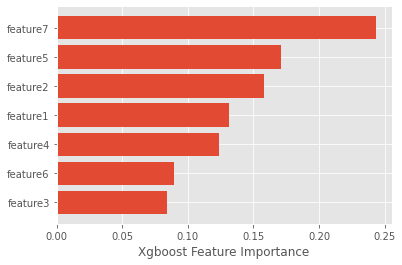

In [11]:
# Promedio de las importancia de las variables para todos los modelos
mean_feature_importance = np.mean(
    list(map(lambda x: x.feature_importances_, classifiers)), axis=0
)

sorted_idx = mean_feature_importance.argsort()
plt.barh(X.columns[sorted_idx], mean_feature_importance[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

#### Test set evaluation

In [12]:
# Promedio de las predicciones con todos los modelos
prediction = []
for classifier in classifiers:
    prediction.append(classifier.predict_proba(X_test))

prediction = np.mean(prediction, axis=0)
prediction = np.argmax(prediction, axis=1)

print(confusion_matrix(y_test, prediction))
print()
print()
print(classification_report(y_test, prediction))

[[1334    1    1]
 [   5   25    2]
 [  15    3   14]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1336
           1       0.86      0.78      0.82        32
           2       0.82      0.44      0.57        32

    accuracy                           0.98      1400
   macro avg       0.89      0.74      0.79      1400
weighted avg       0.98      0.98      0.98      1400



# Results<a class="anchor" id="results"></a>

In [13]:
# Promedio de las predicciones con todos los modelos
prediction = []
for classifier in classifiers:
    prediction.append(classifier.predict_proba(test))

prediction = np.mean(prediction, axis=0)
prediction = np.argmax(prediction, axis=1)


pd.DataFrame(prediction, columns=["results"]).to_csv(
    "results.csv", index=False
)